## Movie Recommendation Predict

Recommender systems play a vital role in today's technology-driven world by helping individuals make informed choices about the content they engage with daily. This is particularly true for movie recommendations, where intelligent algorithms can assist viewers in discovering great titles from a vast selection. Have you ever wondered how streaming platforms like Netflix, Amazon Prime, Showmax, and Disney seem to know what to recommend to you? In this challenge we will walk you through our movie recommender.

![3000.jpeg](attachment:3000.jpeg)

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading The Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>


   <a href=#six>6.1 Kaggle Submission CSV File</a>
   

<a href=#eight>7. Conclusion</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('stopwords')

In [ ]:
#firstly to import important libraries
import pandas as pd
import numpy as np
import io
#for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
#for proceccing the data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
#to display codes without warning
import warnings
warnings.filterwarnings('ignore')

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

There are a few dataframes that are to be imported, so simply importing the data for now and having the information within displayed a little down the line will help keep the notebook more aestheticaly pleasing.

In [ ]:
genome_scores=pd.read_csv("/genome_scores.csv")
genome_tags=pd.read_csv("/genome_tags.csv")
imdb_data= pd.read_csv("/imdb_data.csv")
links= pd.read_csv("/links.csv")
movies= pd.read_csv("/movies.csv")
tags= pd.read_csv("/tags.csv")
df_test=pd.read_csv("/test.csv")
df_train= pd.read_csv("/train.csv")

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having imported all of the data, it becomes clear that there is a lot of data to go through. This might prove dificult to provide an acurate analysis of the data. So to go through it with more ease, a basic EDA function was created to help show the basic information of each dataframe. this EDA function shows if the dataset has: missing values and also the position of the missing values, outliers and their position as well, check the data types, and lastly the correlation of the data.

In [ ]:
def EDA(data):
    """Perform exploratory data analysis on a given dataset.
    Args:
      data (pandas.DataFrame): The dataset to analyze.
    """
    from IPython.display import display
    display(data.head())
    # Check for missing values
    if data.isnull().values.any():
        # Find the number of missing values for each column
        missing_counts = data.isnull().sum()
        # Select only the columns with missing values
        missing_columns = missing_counts[missing_counts > 0]
        print(f"Missing values found in columns: {missing_columns}")
    else:
        print("No missing values found")

    # Check for outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if outliers.empty:
        print("No outliers found")
    else:
        print(f"Outliers found at positions: {outliers.index}")

    # Check data types
    data_types = data.dtypes
    print(f"Data types: {data_types}")

    # Check correlations
    correlations = data.corr()
    display(correlations)

With EDA function above, now it is easier going through each dataframe and perfom simple data exploration. Below this step is completed swiftly

In [ ]:
#fitting the EDA function to the test data as well as the train data
EDA(df_train)

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

No missing values found
Outliers found at positions: RangeIndex(start=0, stop=10000038, step=1)
Data types: userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


userId   movieId    rating  timestamp
userId     1.000000 -0.004270  0.002202  -0.001347
movieId   -0.004270  1.000000 -0.008940   0.520786
rating     0.002202 -0.008940  1.000000   0.010301
timestamp -0.001347  0.520786  0.010301   1.000000

In [ ]:
EDA(df_test)

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

No missing values found
Outliers found at positions: RangeIndex(start=0, stop=5000019, step=1)
Data types: userId     int64
movieId    int64
dtype: object


userId   movieId
userId   1.000000 -0.004401
movieId -0.004401  1.000000

In [ ]:
#firstly the genome score
EDA(genome_scores)

movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075

No missing values found
Outliers found at positions: RangeIndex(start=0, stop=15584448, step=1)
Data types: movieId        int64
tagId          int64
relevance    float64
dtype: object


movieId         tagId  relevance
movieId    1.000000e+00 -1.390078e-13   0.015355
tagId     -1.390078e-13  1.000000e+00   0.017763
relevance  1.535521e-02  1.776320e-02   1.000000

In [ ]:
#genome tags
EDA(genome_tags)

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

No missing values found
Outliers found at positions: RangeIndex(start=0, stop=1128, step=1)
Data types: tagId     int64
tag      object
dtype: object


tagId
tagId    1.0

In [ ]:
#for the imdb data
EDA(imdb_data)

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

Missing values found in columns: title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=27278, step=1)
Data types: movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object


movieId  runtime
movieId  1.00000 -0.13273
runtime -0.13273  1.00000

In [ ]:
#the movies dataframe
EDA(movies)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

No missing values found
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId     int64
title      object
genres     object
dtype: object


movieId
movieId      1.0

In [ ]:
#now the tags
EDA(tags)

userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732       dark comedy  1573943598
3       4     1732    great dialogue  1573943604
4       4     7569  so bad it's good  1573943455

Missing values found in columns: tag    16
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=1093360, step=1)
Data types: userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


userId   movieId  timestamp
userId     1.000000 -0.101326  -0.197582
movieId   -0.101326  1.000000   0.400216
timestamp -0.197582  0.400216   1.000000

In [ ]:
EDA(links)

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Missing values found in columns: tmdbId    107
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId      int64
imdbId       int64
tmdbId     float64
dtype: object


movieId    imdbId    tmdbId
movieId  1.000000  0.466805  0.581131
imdbId   0.466805  1.000000  0.820764
tmdbId   0.581131  0.820764  1.000000

From the above information, it becomes clear that the data contains a few columns missing values, with  missing values found in the 'imdb_data' in only four columns and as well on 'tags' and 'links' having missing value. As for the outliers, the data seems have quite a few outliers. This could be due to the diversity of the data, how the data was entered or a myriad of other reasons. It might prove more fruitful to display the data numerical data and see how much of the data is outlier prone. The data types seem to show that the prominent datatypes are intergers and objects with only 2 columns being float datatypes.

#### Checking the columns with null values
We will have to see how much of the columns from the data which were found to have nulls is missing and if these missing values can be fixed by filling them in anyway or if they have to be dropped later on in the data handling phase

In [ ]:
#to check the percantage of missing data
director_nulls= imdb_data['director'].isnull().mean()
runtime_nulls= imdb_data['runtime'].isnull().mean()
tmdbId_nulls= links['tmdbId'].isnull().mean()
tag_nulls= tags['tag'].isnull().mean()
plot_keywords_nulls= imdb_data['plot_keywords'].isnull().mean()
budget_nulls= imdb_data['budget'].isnull().mean()
# print the percentage of missing data
print("Percentage of missing data in column 'director': {:.2f}%".format(director_nulls*100))
print("Percentage of missing data in column 'runtime': {:.2f}%".format(runtime_nulls*100))
print("Percentage of missing data in column 'budget': {:.2f}%".format(budget_nulls*100))
print("Percentage of missing data in column 'plot_keywords': {:.2f}%".format(plot_keywords_nulls*100))
print("Percentage of missing data in column 'tag': {:.2f}%".format(tag_nulls*100))
print("Percentage of missing data in column 'tmdbId': {:.2f}%".format(tmdbId_nulls*100))

Percentage of missing data in column 'director': 36.20%
Percentage of missing data in column 'runtime': 44.32%
Percentage of missing data in column 'budget': 71.02%
Percentage of missing data in column 'plot_keywords': 40.61%
Percentage of missing data in column 'tag': 0.00%
Percentage of missing data in column 'tmdbId': 0.17%


It would seem that a noticeable chunk of the columns with missing data actually has missing data, with an exception of the 'tag' and the 'tmdbId' column, as it seems the missing values are negligible. This can be seen visually below in the bar chart. This will be addressed in the data handling.

<Figure size 1080x720 with 0 Axes>

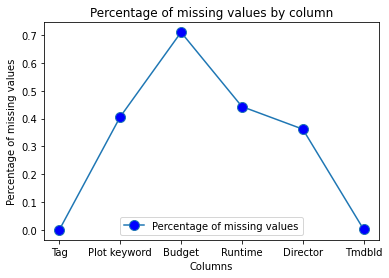

In [ ]:
missing_data={'Tag': tag_nulls, 'Plot keyword': plot_keywords_nulls, 'Budget': budget_nulls,
              'Runtime': runtime_nulls, 'Director': director_nulls, 'TmdbId':tmdbId_nulls}
missing_data = pd.DataFrame(list(missing_data.items()),columns= ['Columns', 'Percentage of missing values'])
plt.figure(figsize=(15, 10))
missing_data.plot(kind='line',x='Columns',y='Percentage of missing values',  
                  marker='o', linestyle='-', markersize=10, markerfacecolor='blue')
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')
plt.title('Percentage of missing values by column')
plt.show()

For more visuals, one would perhaps want to see what relationships can be infered from the data sets or what relationships could be interesting to explore. This will require some creative thinking since some key columns such as budget and runtime are missing a significant amount of data. However below we can see the top 15 highest rated genres.

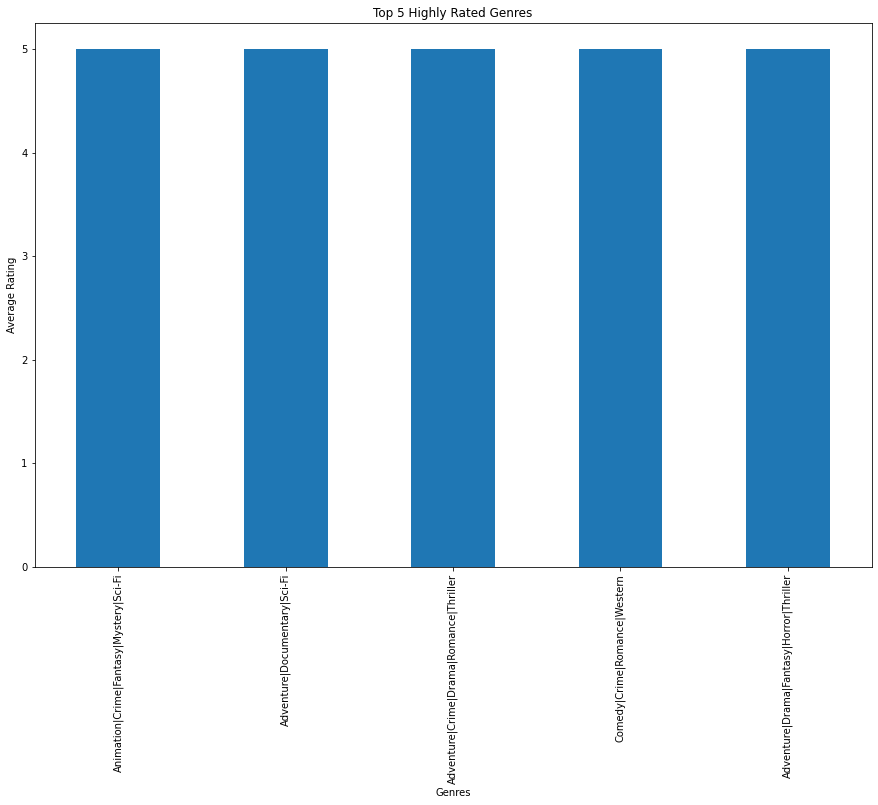

In [ ]:
# merge data on movieId
merged_df = pd.merge(movies, df_train, on='movieId')
# group the data by genre and calculate the mean rating for each group
genre_ratings = merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False)
# select the top 15 highly rated genres
top_genres = genre_ratings.head(5)
# create the bar chart
plt.figure(figsize=(15, 10))
top_genres.plot(kind='bar',xlabel='Genres', ylabel='Average Rating',title='Top 5 Highly Rated Genres')
plt.xticks(rotation=90)
plt.show()

This goes on to show that from some of the most popular genres crime and adventure are the two most highly rated genres. But overall genres such as comedy, drama, fantasy etc all have high ratings of 5.

another thing that can be shown is how the ratings are distributed throughout the dataset as shown below. this piechart shows the percentage of each rating, with the ratings labeled from 0.5 (the lowest) all the way to 5.0 (highest rating) all in intervals of 0.5

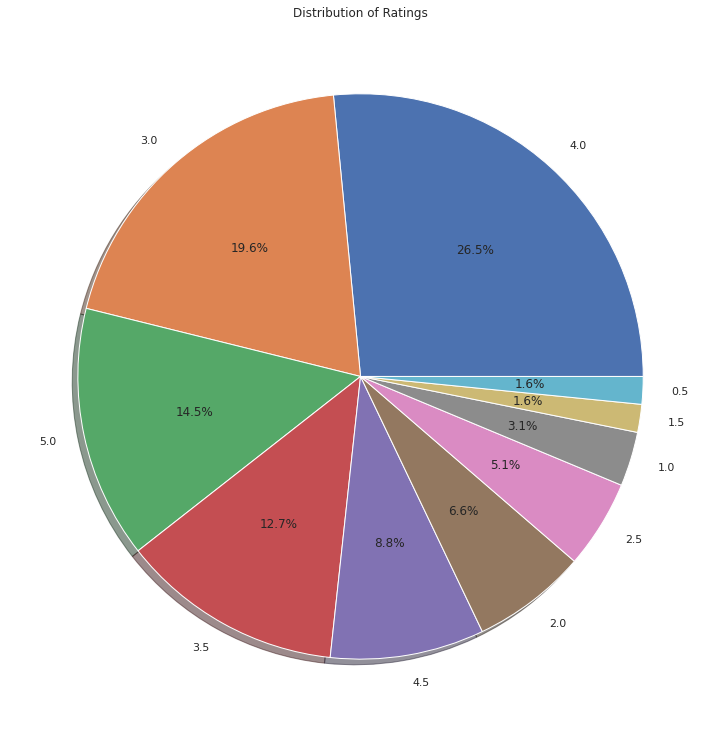

In [ ]:
# Visualize the distribution of ratings
sns.set(rc={'figure.figsize':(27,13)})
rating_counts = df_train['rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Ratings')
plt.show()

but the exploration of the data sets does not end there. When movies are being titled, there could be a method in which movie titles are chosen in way that could results in higher rating or better responses from the audiance. A word cloud can be used to show the most popular words in titles.

In [ ]:
#create a set of english stopwords
stopwords = set(stopwords.words('english'))
#create a list of all the words in the 'title' column
words = ' '.join(movies['title'])
#create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

# plot the wordcloud
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

LookupError: ignored

From the wordcloud it becomes apparent that words like Love, Man and Girl are largly popular when naming a movie. One could, at this point only speculate as to what role naming does to the popularity of a movie. Although it can be said that the name of the movie does play an important role in being as discriptive, eye catching and as relevant as possible so as to attract the intended target market.

With the exploration of the data done as extensively as possible. It is now time to move on to the Data Engineering phase.

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

From the Exploratory Data Analysis, it was made clear that the columns from the imdb data are lacking a significant amount of information. In this phase of the project, it is important to drop those columns

In [ ]:
columns_to_drop = ['director','runtime','budget','plot_keywords']
# drop the specified columns
imdb_data.drop(columns=columns_to_drop, inplace=True)
movies = movies.drop_duplicates()

But the biggest issue that must be avoided is having unnecessary data that to offset the recommender, so in keeping with the etiquette of unsupervised machine learning. A new dataset will be created, one that contains primarily numeric and categorical data.

In [ ]:
#columns we would like added into the training data
movies_genre = movies[['movieId','genres']]
links_ids = links[['movieId','imdbId','tmdbId']]
#merging them
df_train2 = pd.merge(df_train, movies_genre, on='movieId', how='left')
df_train2 = pd.merge(df_train2, links_ids, on='movieId', how='left')
df_train2

Once that part is done, we can move on to scaling the data. This is easily the biggest and most important step. 

In [ ]:
scaler = StandardScaler()
# Fit and transform the dataframe
scaled_final_df = scaler.fit_transform(df_train)

With the data engineering part done, we can move on to the modelling phase of the project

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [ ]:
df_test['rating'] = df_test.assign(rating=None)['rating'].astype(float)
df_test

userId  movieId  rating
0             1     2011     NaN
1             1     4144     NaN
2             1     5767     NaN
3             1     6711     NaN
4             1     7318     NaN
...         ...      ...     ...
5000014  162541     4079     NaN
5000015  162541     4467     NaN
5000016  162541     4980     NaN
5000017  162541     5689     NaN
5000018  162541     7153     NaN

[5000019 rows x 3 columns]

In [ ]:
df_trainreq = df_train.drop(columns=['timestamp']).reset_index(drop=True)
df_trainreq

userId  movieId  rating
0           5163    57669     4.0
1         106343        5     4.5
2         146790     5459     5.0
3         106362    32296     2.0
4           9041      366     3.0
...          ...      ...     ...
10000033  136395    99114     5.0
10000034  140078      553     3.0
10000035  154807    56782     4.0
10000036   85805      327     4.0
10000037  139457     1009     4.0

[10000038 rows x 3 columns]

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
# Load the train and test data into surprise's dataset format
train_data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)
test_data = Dataset.load_from_df(df_test[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
train_set = train_data.build_full_trainset()
test_set = test_data.build_full_trainset().build_testset()


# Train the model using the SVD algorithm
algo = SVD()
algo.fit(train_set)

# Predict ratings for the test set
svg_pred = algo.test(test_set)

In [ ]:
predicted_ratings = []

# Step 2: Iterate through the svg_pred list and append the est attribute to the list
for pred in svg_pred:
    predicted_ratings.append(pred.est)

In [ ]:
df_test['rating']=predicted_ratings

In [ ]:
df_test['Id'] = df_test['userId'].astype(str) + '_' + df_test['movieId'].astype(str)

In [ ]:
df_test = df_test.drop(['userId', 'movieId'], axis=1)

In [ ]:
df_test['rating'] = df_test['rating'].round(1)
df_test

rating           Id
0           3.0       1_2011
1           4.1       1_4144
2           3.6       1_5767
3           4.1       1_6711
4           3.3       1_7318
...         ...          ...
5000014     3.5  162541_4079
5000015     3.8  162541_4467
5000016     3.1  162541_4980
5000017     3.0  162541_5689
5000018     5.0  162541_7153

[5000019 rows x 2 columns]

In [ ]:
submission = df_test.reindex(columns=['Id', 'rating'])
submission.head()


Id  rating
0  1_2011     3.0
1  1_4144     4.1
2  1_5767     3.6
3  1_6711     4.1
4  1_7318     3.3

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import xgboost as xgb

# Prepare the data for training
X_train = df_train[['userId', 'movieId']]
y_train = df_train['rating']
X_test = df_test[['userId', 'movieId']]

# Create the XGBoost model
xgb_model = xgb.XGBRegressor()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Predict ratings for the test set
xgb_predictions = xgb_model.predict(X_test)

[12:24:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:40] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
import pandas as pd
xgb_predictions_df = pd.DataFrame(xgb_predictions, columns = ['rating'])

In [ ]:
df_test['Id'] = df_test['userId'].astype(str) + '_' + df_test['movieId'].astype(str)

In [ ]:
df_test['rating'] = xgb_predictions_df
df_test

userId  movieId           Id    rating
0             1     2011       1_2011  3.460360
1             1     4144       1_4144  3.426196
2             1     5767       1_5767  3.428380
3             1     6711       1_6711  3.489059
4             1     7318       1_7318  3.541879
...         ...      ...          ...       ...
5000014  162541     4079  162541_4079  3.423837
5000015  162541     4467  162541_4467  3.386369
5000016  162541     4980  162541_4980  3.615871
5000017  162541     5689  162541_5689  3.425846
5000018  162541     7153  162541_7153  3.548135

[5000019 rows x 4 columns]

In [ ]:
df_test = df_test.drop(['userId', 'movieId'], axis=1)

In [ ]:
df_test['rating'] = df_test['rating'].round(1)
df_test

Id  rating
0             1_2011     3.5
1             1_4144     3.4
2             1_5767     3.4
3             1_6711     3.5
4             1_7318     3.5
...              ...     ...
5000014  162541_4079     3.4
5000015  162541_4467     3.4
5000016  162541_4980     3.6
5000017  162541_5689     3.4
5000018  162541_7153     3.5

[5000019 rows x 2 columns]

In [ ]:
xgbsubmission=df_test


In [ ]:
xgbsubmission.to_csv('submission.csv', index=False)
xgbsubmission

Id  rating
0             1_2011     3.5
1             1_4144     3.4
2             1_5767     3.4
3             1_6711     3.5
4             1_7318     3.5
...              ...     ...
5000014  162541_4079     3.4
5000015  162541_4467     3.4
5000016  162541_4980     3.6
5000017  162541_5689     3.4
5000018  162541_7153     3.5

[5000019 rows x 2 columns]

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Define the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

# Fit the model to the training data
knn_model.fit(train_set, train_set['rating'])

# Make predictions on the test set
knn_predictions = knn_model.predict(test_set)

TypeError: ignored

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def check_rmse(predictions, actual):
    """
    Calculates the root mean squared error (RMSE) between the predictions and actual values.
    """
    mse = mean_squared_error(predictions, actual)
    rmse = sqrt(mse)
    return rmse

# Use the function to check the RMSE of the SVD model
svd_predictions = svd_model.predict(test_set)
print("SVD RMSE: ", check_rmse(svd_predictions, actual))

# Use the function to check the RMSE of the xgboost model
xgb_predictions = xgb_model.predict(dtest)
print("XGBoost RMSE: ", check_rmse(xgb_predictions, actual))


In [ ]:
for prediction in predictions:
    df_test.loc[(df_test['userId'] == prediction.uid) & (df_test['movieId'] == prediction.iid), 'rating'] = prediction.est

In [ ]:
pred = pd.DataFrame(pred, columns=['rating'])
pred.head()

In [ ]:
df_test['rating']=pred
submission = df_test[['userId', 'rating']]
submission.to_csv('randomsubmission.csv')
submission.head()

the model chosen do our predictions first woudl be a DBSCAN model. Main reason is the data has shown to have outliers and from the correlation from the EDA the data might not regularly shaped.

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)

dbscan.fit(scaled_df_train2)

labels = dbscan.labels_

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>